## Bayesian Opt for Qubit

We have a qubit in the state $$|\psi> = \frac{1}{\sqrt{2}}(|0> + e^{i\phi}|1>)$$ where $\phi$ is unknown. The measurement operator is $$ \hat{M} = \cos{\alpha} X + \sin{\alpha} Y $$. Measuring $\hat{M}$ on a state means looking for its projections along two opposite vectors (meaning with a phase difference of $\pi$) in the $X-Y$ plane that we call $|up> = \frac{1}{\sqrt{2}}(|0> + e^{i\alpha}|1>)$ and $|down> = \frac{1}{\sqrt{2}}(|0> + e^{-i\alpha}|1>$. Measuring $\hat{M}$ to the state $|\psi>$ produces on of the two outcomes $\gamma$ with probability: $$P(up) = \frac{1}{2}(1 + \cos(\phi - \alpha)) \quad P(down) = \frac{1}{2}(1 - \cos(\phi - \alpha))$$

So we start with a uniform prior, we fix $\alpha$ in three different manners, see below. At each iteration we sample one of the two outcomes according to their probabilities (which represent the result of a real experiment), calculate the likelihood distribution as $\frac{1}{2}(1 \pm \cos(\phi - \alpha))$ if the outcome was up/down and where $\phi$ is the unknown variable, so it runs in a range like 0 to $2*\pi$ (with N values, N can be set). Then the current posterior becomes the following prior and so on.
Final posterior distribution is plotted. 

### Fixed $\alpha$
In the case of $\alpha$ fixed for all the sampling:
The shape of the posterior will be given by: $$ P(\phi| n_+, N) = [ \frac{1}{2}(1 + \cos(\phi - \alpha)]^{n_+}[\frac{1}{2}(1 - \cos(\phi - \alpha)]^{N- n_+}$$
which has two maxima in $$\max_{\phi} P(\phi| n_+, N)_{MAX} = \alpha \pm \arccos [2\frac{n_+}{N} - 1] $$
and only one maxima if $\arccos [2\frac{n_+}{N} - 1]$ which happens when $2\frac{n_+}{N} - 1 = 0$.
The two maxima do not correspond to equal physical solutions, only one is correct (right?)
### Random Search
At each iteration we pick a new random alpha
### Entropy Search
at each iteration we calculate the next alpha as the value which maximizes the variation in entropy at the next sampling, aka: $$ \alpha_{t+1} = \arg \max_{\alpha} \{\mathbb{H}[P(\phi | \mathcal{D})] - \mathbb{E}_{P(\gamma | \alpha, \mathcal{D})}[\mathbb{H}[P(\phi| \gamma, \alpha, \mathcal{D}]]\} $$
where 
- $\mathbb{H}[P(\phi | \mathcal{D})$ is the entropy of the current posterior
- $P(\gamma | \alpha, \mathcal{D})$ is the probability of obtaining results $\gamma$ which is a discrete distribution because the oucomes are either up or down along $\alpha$, which is fixed and the measure is independent of the Dataset, alias the old measurements
- $\mathbb{H}[P(\phi| \gamma, \alpha, \mathcal{D}]$ Entropy of the posterior that we would have if we chose a specific $\alpha$ and thus obtained a particular outcome $\gamma$.
Puttin al together, while the first term is easy to calculate with scipy.stats.entropy, the second term is calculated with 
$$\mathbb{E}_{P(\gamma | \alpha, \mathcal{D})}[\mathbb{H}[P(\phi| \gamma, \alpha, \mathcal{D}]]\} = \sum_{\gamma_i = "up"/"down"} P(\gamma_i| \alpha)\big[-\sum_\phi P(\phi| \alpha, \mathcal{D})*\log P(\phi| \alpha, \mathcal{D})\big]$$

### Fixed Alpha

Entropy at step 0/1000: 6.625879807397178
Entropy at step 10/1000: 5.961341761962574
Entropy at step 20/1000: 5.659594354643128
Entropy at step 30/1000: 5.471993120249316
Entropy at step 40/1000: 5.335802034430878
Entropy at step 50/1000: 5.229511418169621
Entropy at step 60/1000: 5.141587797994379
Entropy at step 70/1000: 5.066848927504388
Entropy at step 80/1000: 5.001769215242832
Entropy at step 90/1000: 4.944506543663408
Entropy at step 100/1000: 4.892989406777838
Entropy at step 110/1000: 4.846222163250502
Entropy at step 120/1000: 4.80348519354982
Entropy at step 130/1000: 4.764092691483605
Entropy at step 140/1000: 4.727558652392267
Entropy at step 150/1000: 4.6935141934568225
Entropy at step 160/1000: 4.661679867214905
Entropy at step 170/1000: 4.631717595309848
Entropy at step 180/1000: 4.603466809306504
Entropy at step 190/1000: 4.5767129306938275
Entropy at step 200/1000: 4.551359804116215
Entropy at step 210/1000: 4.527204599858148
Entropy at step 220/1000: 4.50418402517625

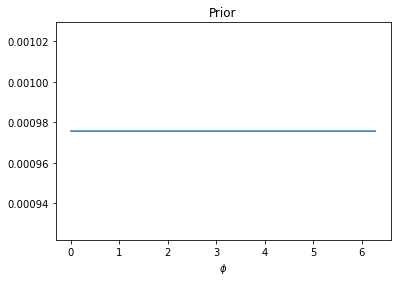

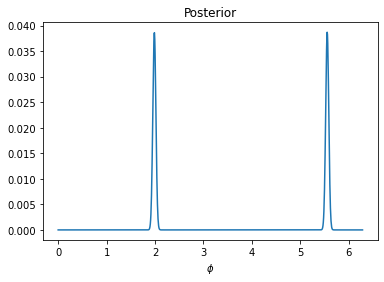

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.integrate as integrate
import scipy.stats as stats
from tqdm import tqdm


alpha = np.pi/5  #operator is M = cos \alpha X + cos \alpha Y with \alpha fixed for now
N = 2**10+1     #N of points to generate distribution, the integrate.romb function needs 2^k + 1 samples to integrate.
real_phi = np.pi*7/4  #Real value to learn
repetitions = 1000  #How many times run the Bayes iteration

phi = np.linspace(0, 2*np.pi, N)  
prior = 1/(N)*np.ones(N) #1/np.pi?

fig = plt.figure(1)
plt.title('Prior')
plt.plot(phi, prior)
plt.xlabel('$\phi$')
n_plus = 0
error_fixed_alpha = []
run_entropy_fixed_alpha = []

for i in range(repetitions):
    prob = 1/2*(1 + np.cos(real_phi-alpha))    #Probability of measuring the first of the two eigenstates
    if random.random() <= prob:
        n_plus += 1
        likelihood = 1/2*(1 + np.cos(phi-alpha))
        norm = integrate.romb(likelihood*prior)
    else:
        likelihood = 1/2*(1 - np.cos(phi-alpha))
        norm = integrate.romb(likelihood*prior)
    posterior = prior*likelihood/norm
    prior = posterior
    run_entropy_fixed_alpha.append(stats.entropy(posterior))
    if i %10 == 0:
        print('Entropy at step {}/{}: {}'.format(i,repetitions, run_entropy_fixed_alpha[-1]))
    error_fixed_alpha.append(np.abs(real_phi - phi[np.argmax(posterior)]))

fig = plt.figure(3)
plt.title('Posterior')
plt.plot(phi, posterior)
plt.xlabel('$\phi$')

max0, max1 = sorted(zip(phi,posterior), key=lambda t:t[1], reverse=True)[:2]
print('Two most likely values of phi are: {}, {}'.format(max0[0], max1[0]))
print('Real value is {}'.format(real_phi))
print('Number of positive outcomes n_+/N: {}/{}'.format(n_plus, repetitions))
print('Phi should be max at {} and {}'.format(np.arccos(2*n_plus/repetitions - 1) + alpha,
                                                     (-np.arccos(2*n_plus/repetitions - 1) + alpha) ))

### Random Search
It seems tha entropy decreases more w.r.t. the number of steps in the fixed alpha case. 

Entropy at step 0/1000: 6.625879807397178
Entropy at step 1/1000: 6.358530208271787
Entropy at step 2/1000: 6.11126491068895
Entropy at step 3/1000: 6.00353780476151
Entropy at step 4/1000: 5.832195886254
Entropy at step 5/1000: 5.633233140678054
Entropy at step 6/1000: 5.568737903242831
Entropy at step 7/1000: 5.52195872560646
Entropy at step 8/1000: 5.4556739673075105
Entropy at step 9/1000: 5.415413447027549
Entropy at step 10/1000: 5.327034309699266
Entropy at step 11/1000: 5.297940353897915
Entropy at step 12/1000: 5.266773522414964
Entropy at step 13/1000: 5.201842867828422
Entropy at step 14/1000: 5.130905565470338
Entropy at step 15/1000: 5.056637237674122
Entropy at step 16/1000: 5.015680746229687
Entropy at step 17/1000: 5.002997818787296
Entropy at step 18/1000: 4.972489473746936
Entropy at step 19/1000: 4.954321946580504
Entropy at step 20/1000: 4.940150878344944
Entropy at step 21/1000: 4.925390841874827
Entropy at step 22/1000: 4.901593514115585
Entropy at step 23/1000: 4

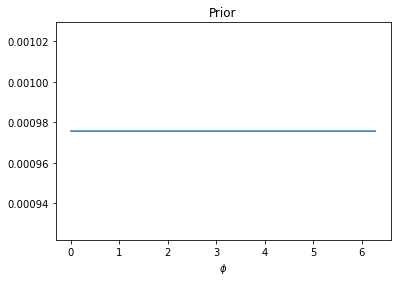

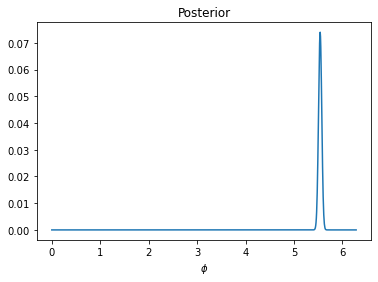

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.integrate as integrate
from tqdm import tqdm
import scipy.stats as stats



alpha = np.pi/5  #operator is M = sin \alpha X + cos \alpha Y with \alpha fixed for now
N = 2**10+1     #N of points to generate distribution, the integrate.romb function needs 2^k + 1 samples to integrate.
real_phi = np.pi*7/4  #Real value to learn
repetitions = 1000  #How many times run the Bayes iteration

phi = np.linspace(0, 2*np.pi, N)  
prior = 1/(N)*np.ones(N) #1/np.pi?

fig = plt.figure(1)
plt.title('Prior')
plt.plot(phi, prior)
plt.xlabel('$\phi$')
n_plus = 0
error_random_alpha = []
run_entropy_random_alpha = []
random_post_means = []
random_post_vars = []

for i in range(repetitions):
    #Bayesian Update
    prob = 1/2*(1 + np.cos(real_phi-alpha))    #Probability of measuring the first of the two eigenstates
    if random.random() <= prob:
        n_plus += 1
        likelihood = 1/2*(1 + np.cos(phi-alpha))
        norm = integrate.romb(likelihood*prior)
    else:
        likelihood = 1/2*(1 - np.cos(phi-alpha))
        norm = integrate.romb(likelihood*prior)
    posterior = prior*likelihood/norm
    prior = posterior
    
    #Entropy
    entropy = stats.entropy(posterior)
    run_entropy_random_alpha.append(entropy)
    print('Entropy at step {}/{}: {}'.format(i,repetitions,entropy))
    
    possible_alpha = np.linspace(0, 2*np.pi, 2**7 + 1)
    alpha = np.random.uniform(2*np.pi)
    error_random_alpha.append(np.abs(real_phi - phi[np.argmax(posterior)]))
    
    #Stats
    post_mean = integrate.romb(posterior*phi)
    post_var = integrate.romb(posterior*(phi - post_mean)**2)
    random_post_means.append(post_mean)
    random_post_vars.append(post_var)

fig = plt.figure(3)
plt.title('Posterior')
plt.plot(phi, posterior)
plt.xlabel('$\phi$')

max0, max1 = sorted(zip(phi,posterior), key=lambda t:t[1], reverse=True)[:2]
print('Two most likely values of phi are: {}, {}'.format(max0[0], max1[0]))
print('Real value is {}'.format(real_phi))
print('Number of positive outcomes n_+/N: {}/{}'.format(n_plus, repetitions))
print('Phi should be max at {} and {}'.format(np.arcsin(2*n_plus/repetitions - 1) + alpha,
                                                     (-np.arcsin(2*n_plus/repetitions - 1) + alpha) ))

### Entropy Search

In the first approach at each iteration the new alpha is chosen by taking the value which maximizes the variation in entropy. This produces a search for alpha that tends to the real value of $\phi$ but only from one side, so we introduce an $\epsilon$-greedy policy that at each step $i$ produces a random $\alpha$ with probability $\epsilon_i = \frac{1}{i}$ to favor exploration in the first steps of the training.

Step 0/300: S:6.626, alpha: 3.001
Step 10/300: S:5.371, alpha: 1.963
Step 20/300: S:5.132, alpha: 1.743
Step 30/300: S:4.976, alpha: 1.767
Step 40/300: S:4.638, alpha: 1.424
Step 50/300: S:4.558, alpha: 1.399
Step 60/300: S:4.489, alpha: 1.387
Step 70/300: S:4.348, alpha: 1.289
Step 80/300: S:4.243, alpha: 2.344
Step 90/300: S:4.192, alpha: 1.154
Step 100/300: S:4.096, alpha: 1.080
Step 110/300: S:4.063, alpha: 1.080
Step 120/300: S:4.033, alpha: 1.068
Step 130/300: S:4.005, alpha: 1.068
Step 140/300: S:3.980, alpha: 1.068
Step 150/300: S:3.896, alpha: 1.019
Step 160/300: S:3.873, alpha: 1.019
Step 170/300: S:3.817, alpha: 3.068
Step 180/300: S:3.805, alpha: 1.215
Step 190/300: S:3.779, alpha: 1.092
Step 200/300: S:3.757, alpha: 1.043
Step 210/300: S:3.738, alpha: 1.019
Step 220/300: S:3.720, alpha: 1.006
Step 230/300: S:3.703, alpha: 0.994
Step 240/300: S:3.688, alpha: 0.982
Step 250/300: S:3.673, alpha: 0.982
Step 260/300: S:3.659, alpha: 0.982
Step 270/300: S:3.645, alpha: 0.969
Ste

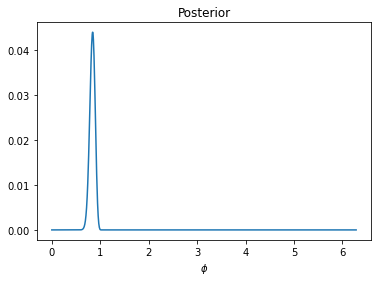

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.integrate as integrate
from tqdm.notebook import tqdm
import scipy.stats as stats

alpha = np.pi/5  #initial value of alpha
N = 2**10+1     #N of points to generate distribution, the integrate.romb function needs 2^k + 1 samples to integrate.
real_phi = np.pi/4  #Real value to learn
repetitions = 300  #How many times run the Bayes iteration

phi = np.linspace(0, 2*np.pi, N)  
prior = 1/(N)*np.ones(N) #1/np.pi?

n_plus = 0
run_entropy_search = []
error_search = []
alpha_search = []
posteriors = []
entropy_post_means = []
entropy_post_vars = []
entropy_difference = []

def expected_entropy(possible_alpha, prior):
    expected_entropies = []
    
    for alpha in possible_alpha:
        prob_up = 1/2*(1 + np.cos(real_phi-alpha))
        prob_down = 1 - prob_up
        likelihood_up = 1/2*(1 + np.cos(phi-alpha))
        likelihood_down = 1 - likelihood_up
        norm_up = integrate.romb(likelihood_up*prior)
        norm_down = integrate.romb(likelihood_down*prior)
        posterior_up = prior*likelihood_up/norm_up
        posterior_down = prior*likelihood_down/norm_down
        expected_entropies.append(prob_up*(stats.entropy(posterior_up)) + 
                                     prob_down*(stats.entropy(posterior_down)))
    return expected_entropies

for i in tqdm(range(repetitions)):
    #Bayesian Update
    prob = 1/2*(1 + np.cos(real_phi-alpha))    #Probability of measuring the first of the two eigenstates
    if random.random() <= prob:
        n_plus += 1
        likelihood = 1/2*(1 + np.cos(phi-alpha))
        norm = integrate.romb(likelihood*prior)
    else:
        likelihood = 1/2*(1 - np.cos(phi-alpha))
        norm = integrate.romb(likelihood*prior)
    posterior = prior*likelihood/norm
    prior = posterior
    
    #Entropy
    posterior_entropy = stats.entropy(posterior)
    run_entropy_search.append(posterior_entropy)

    #Choice of alpha: random or maximizing entropy according to prob epsilon
    epsilon = 1/(i+1)
    if np.random.uniform() > epsilon:
        possible_alpha = np.linspace(0,np.pi, 2**8 + 1)            
        exp_entropy = expected_entropy(possible_alpha, posterior)
        alpha_index = np.argmax(posterior_entropy - exp_entropy)
        entropy_difference.append(posterior_entropy - exp_entropy)
        alpha = possible_alpha[alpha_index]
    else:
        alpha = np.random.uniform(0, np.pi)
        
    error_search.append(np.abs(real_phi - phi[np.argmax(posterior)]))
    posteriors.append(posterior)
    alpha_search.append(alpha)
    
    #Stats
    post_mean = integrate.romb(posterior*phi)
    post_var = integrate.romb(posterior*(phi - post_mean)**2)
    entropy_post_means.append(post_mean)
    entropy_post_vars.append(post_var)
    if i%10 == 0:
        print('Step {}/{}: S:{:.3f}, alpha: {:.3f}'.format(i,repetitions, run_entropy_search[-1], alpha))
    

fig = plt.figure(3)
plt.title('Posterior')
plt.plot(phi, posterior)
plt.xlabel('$\phi$')

max0, max1 = sorted(zip(phi,posterior), key=lambda t:t[1], reverse=True)[:2]
print('Two most likely values of phi are: {}, {}'.format(max0[0], max1[0]))
print('Real value is {}'.format(real_phi))
print('Number of positive outcomes n_+/N: {}/{}'.format(n_plus, repetitions))

### Observations 
- The plots are, in order:
    - Entropies of the different approaches for iteration step
    - Error, as the absolute difference between the most likely $\phi$ and the real_phi
    - Error, as the variance of the posterior
    - Histogram representing the $\alpha$s at which the measurement was performed
    - First four posteriors and the sequent position of $\alpha$ where the measurement will be performed (most informative direction)

#### Entropies

- Random Search and Entropy Search seem to converge with the same velocity and precision


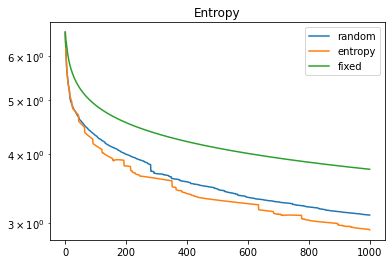

In [8]:
fig = plt.figure()
plt.title('Entropy')
plt.plot(run_entropy_random_alpha, label = 'random')
plt.plot(run_entropy_search, label = 'entropy')
plt.plot(run_entropy_fixed_alpha, label = 'fixed')
#plt.xscale('log')
plt.yscale('log')
plt.legend()

#### Error


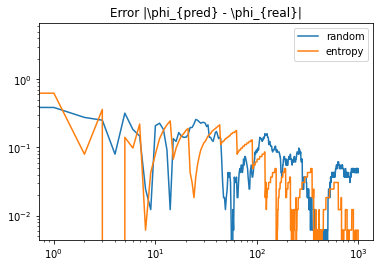

In [9]:
fig = plt.figure()
plt.title('Error |\phi_{pred} - \phi_{real}|')
#plt.plot(error_fixed_alpha, label = 'fixed')
plt.plot(error_random_alpha, label = 'random')
plt.plot(error_search, label = 'entropy')
plt.yscale('log')
plt.xscale('log')
plt.legend()


#### Error, variance

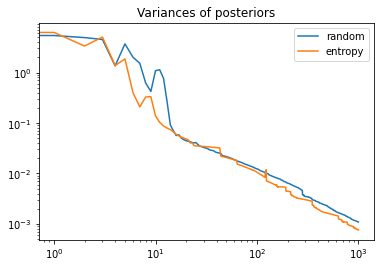

In [10]:
fig = plt.figure()
plt.title('Variances of posteriors')
plt.plot(random_post_vars, label = 'random')
plt.plot(entropy_post_vars, label = 'entropy')
plt.yscale('log')
plt.xscale('log')
plt.legend()

#### Alphas where measurement is performed

- Entropy Search seems to align $\alpha$ to $\phi^*$ ($\pm \pi$), the redundancy due to the fact that measuring $\alpha$ or $-\alpha$ is the same thing.

Text(0, 0.5, 'Measurements')

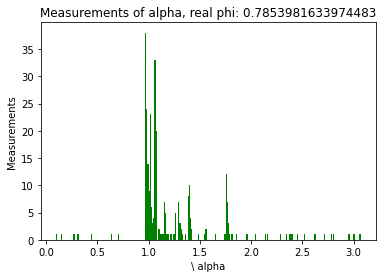

In [22]:
fig = plt.figure()
plt.title('Measurements of alpha, real phi: {}'.format(real_phi))
plt.hist(alpha_search, bins = len(possible_alpha), color = 'green')
plt.xlabel('\ alpha')
plt.ylabel('Measurements')

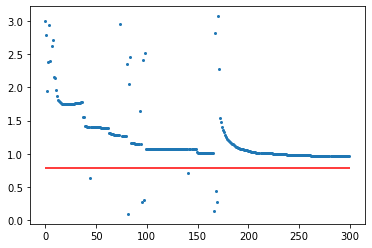

In [23]:
fig = plt.figure()
plt.plot(alpha_search, marker = 'o', linestyle = 'none', markersize = 2)
plt.hlines(real_phi % np.pi, 0, repetitions, color = 'red')

#### Firt N posteriors with the position where alpha is more informative 

At each iteration we calculate with entropy search the alpha which maximizes the variance in entropy and here we plot the first $N$ posteriors along with the alpha decided for the next measurement by the entropy search method

- It seems like the paper https://arxiv.org/pdf/1107.0895.pdf where the most informative direction is (are beacuse you are basicall measuring along both $\alpha$ and $\alpha \pm \pi$) the one that separates the points wich larger/smaller density function (where the posterior is largest and smallest). Does it make sense? Or should we expect the opposite, like an alpha pointing exactly in the middle of the most dense part?

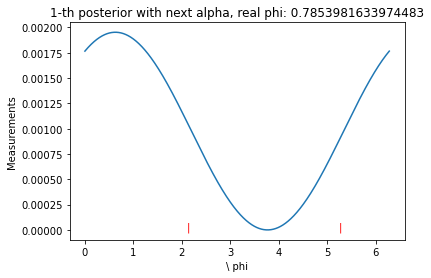

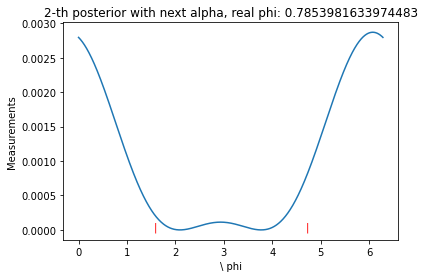

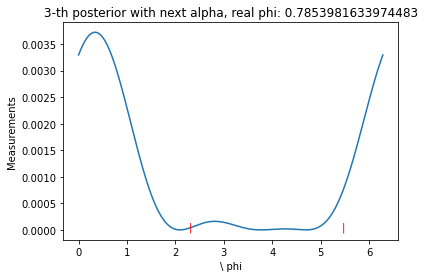

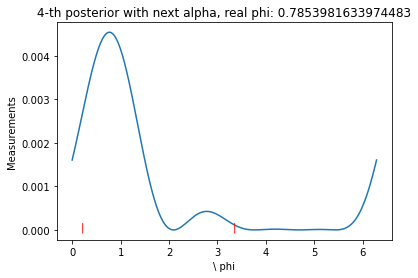

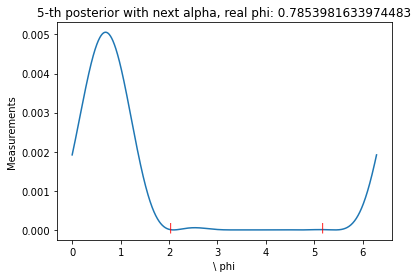

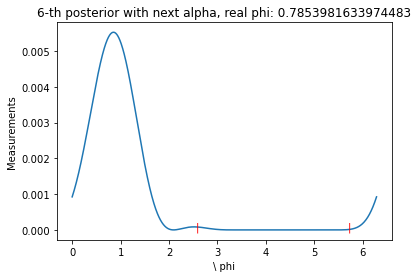

In [27]:
n = 6
for i in range(n):
    fig = plt.figure()
    plt.title('{}-th posterior with next alpha, real phi: {}'.format(i+1, real_phi))
    plt.text(alpha_search[i], 0, '|', color = 'red')
    if alpha_search[i] < np.pi:
        plt.text(alpha_search[i] + np.pi, 0, '|', color = 'red')
    else:
        plt.text(alpha_search[i] - np.pi, 0, '|', color = 'red')
    plt.plot(phi,posteriors[i])
    plt.xlabel('\ phi')
    plt.ylabel('Measurements')

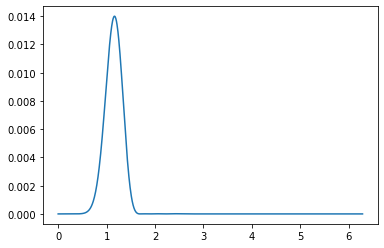

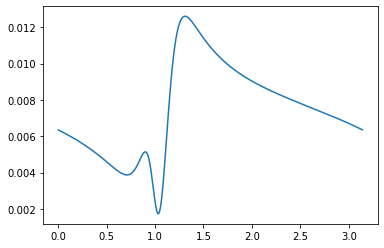

In [5]:
n = 30

fig = plt.figure()
x1 = np.linspace(0, 2*np.pi,2**10+1)
plt.plot(x1, posteriors[n])
fig = plt.figure()
x1 = np.linspace(0, 2*np.pi,2**10+1)
plt.plot(x1, posteriors[n])
fig = plt.figure()
x2 = np.linspace(0, np.pi,2**8+1)
plt.plot(x2, entropy_difference[n])
#print(x1[np.argmax(posteriors[n])], x2[np.argmin(posteriors[n])])

### Other visualization

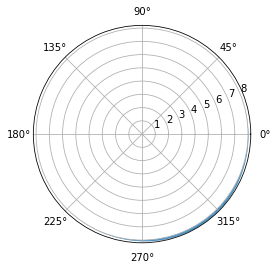

In [175]:
#https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python

N = 1000
bottom = 8
max_height = 40

theta = phi
radii = posteriors[4]*max_height
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# Use custom colors and opacity
#for r, bar in zip(radii, bars):
 #   bar.set_facecolor(plt.cm.jet(r / 10.))
  #  bar.set_alpha(0.8)

plt.show()

In [3]:
a = np.array[3,2,5]
a.sort()

In [4]:
a


[2, 3, 5]